# Baseline: 基于CLIP的zero-shot分类

In [1]:
import warnings
warnings.filterwarnings('ignore')

### 查看CLIP所有模型版本

In [2]:
import clip
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

### 读取类别并构造用于分类的Prompt

In [6]:
import json

cl_list = json.load(open("./data/class_to_id.json")).keys()
print(json.load(open("./data/class_to_id.json")))

{'passion flower': 0, 'water lily': 1, 'cyclamen': 2, 'watercress': 3, 'frangipani': 4, 'wallflower': 5, 'rose': 6, 'petunia': 7, 'clematis': 8, 'hibiscus': 9, 'lotus': 10, 'thorn apple': 11, 'barbeton daisy': 12, 'sword lily': 13, 'geranium': 14, 'bishop of llandaff': 15, 'pink-yellow dahlia': 16, 'cape flower': 17, 'foxglove': 18, 'bougainvillea': 19, 'Boeing 707': 20, 'Boeing 737': 21, 'Boeing 747': 22, 'Boeing 757': 23, 'Boeing 767': 24, 'Boeing 777': 25, 'A300': 26, 'A320': 27, 'A330': 28, 'A340': 29, 'A380': 30, 'An-12': 31, 'BAE 146': 32, 'CRJ-700': 33, 'Cessna Citation': 34, 'Dash 8': 35, 'Embraer E-Jet': 36, 'Embraer ERJ 145': 37, 'Gulfstream': 38, 'MD-80': 39, 'porous': 40, 'matted': 41, 'wrinkled': 42, 'interlaced': 43, 'veined': 44, 'stained': 45, 'honeycombed': 46, 'woven': 47, 'spiralled': 48, 'bumpy': 49, 'lined': 50, 'striped': 51, 'lacelike': 52, 'cracked': 53, 'bubbly': 54, 'scaly': 55, 'stratified': 56, 'pleated': 57, 'gauzy': 58, 'waffled': 59}


In [7]:
prompt_list = ["A photo of a {}".format(cl_name) for cl_name in cl_list]
prompt_list

['A photo of a passion flower',
 'A photo of a water lily',
 'A photo of a cyclamen',
 'A photo of a watercress',
 'A photo of a frangipani',
 'A photo of a wallflower',
 'A photo of a rose',
 'A photo of a petunia',
 'A photo of a clematis',
 'A photo of a hibiscus',
 'A photo of a lotus',
 'A photo of a thorn apple',
 'A photo of a barbeton daisy',
 'A photo of a sword lily',
 'A photo of a geranium',
 'A photo of a bishop of llandaff',
 'A photo of a pink-yellow dahlia',
 'A photo of a cape flower',
 'A photo of a foxglove',
 'A photo of a bougainvillea',
 'A photo of a Boeing 707',
 'A photo of a Boeing 737',
 'A photo of a Boeing 747',
 'A photo of a Boeing 757',
 'A photo of a Boeing 767',
 'A photo of a Boeing 777',
 'A photo of a A300',
 'A photo of a A320',
 'A photo of a A330',
 'A photo of a A340',
 'A photo of a A380',
 'A photo of a An-12',
 'A photo of a BAE 146',
 'A photo of a CRJ-700',
 'A photo of a Cessna Citation',
 'A photo of a Dash 8',
 'A photo of a Embraer E-Je

### 使用CLIP模型分类

加载数据

In [10]:
import os
from pathlib import Path
import pandas as pd

class_to_id = json.load(open("./data/class_to_id.json"))
id_to_class = {v:k for k,v in class_to_id.items()}

train_dir = "./data/train/"
train_df = pd.read_csv("./data/train.tsv", sep="\t")
print(train_df)

train_image_paths = [f"{train_dir}{name}" for name in train_df["img_name"].tolist()]
train_labels = train_df["label"].tolist()

     Unnamed: 0  img_name  label
0             0  0000.jpg      0
1             1  0001.jpg      0
2             2  0002.jpg      0
3             3  0003.jpg      0
4             4  0004.jpg      0
..          ...       ...    ...
955         955  0955.jpg     59
956         956  0956.jpg     59
957         957  0957.jpg     59
958         958  0958.jpg     59
959         959  0959.jpg     59

[960 rows x 3 columns]


加载CLIP模型

In [11]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
random.seed(1)

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('RN50', device)

print(model)

CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
     

<Figure size 1200x1000 with 0 Axes>

将文本token化

In [14]:
text_inputs = clip.tokenize(prompt_list).to(device)
print(text_inputs)

tensor([[49406,   320,  1125,  ...,     0,     0,     0],
        [49406,   320,  1125,  ...,     0,     0,     0],
        [49406,   320,  1125,  ...,     0,     0,     0],
        ...,
        [49406,   320,  1125,  ...,     0,     0,     0],
        [49406,   320,  1125,  ...,     0,     0,     0],
        [49406,   320,  1125,  ...,     0,     0,     0]], device='cuda:0',
       dtype=torch.int32)


使用CLIP计算图文相似度，并和正确标签对比

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 960/960 [00:27<00:00, 35.39it/s]


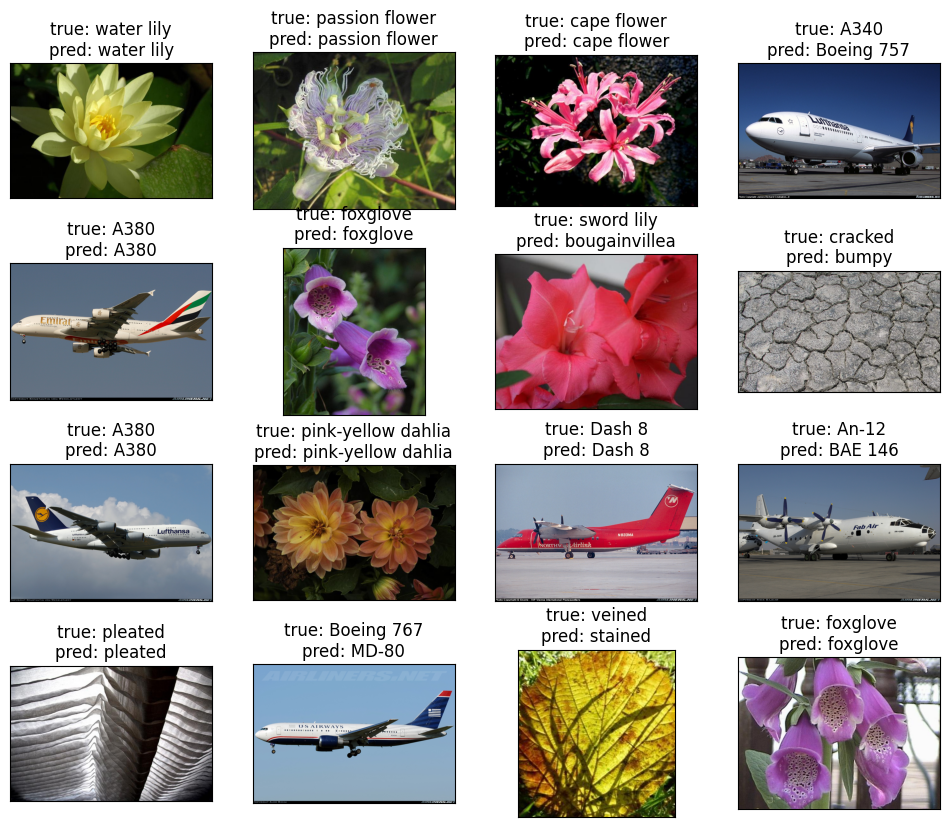

In [16]:
plt.figure(figsize=(12, 10))

with torch.no_grad():
    text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    path_label_list = list(zip(train_image_paths, train_labels))
    random.shuffle(path_label_list)

    pred_labels = []
    true_labels = [label for (path, label) in path_label_list]
    
    for ii, (img_path, label) in enumerate(tqdm(path_label_list)):
        image = Image.open(img_path)
        image_input = preprocess(image).unsqueeze(0).to(device)
        image_features = model.encode_image(image_input)

        image_features /= image_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        pred = similarity.max(dim=-1)[-1].item()

        if ii < 16:
            plt.subplot(4, 4, ii+1)
            plt.xticks([])
            plt.yticks([])
            plt.title(f"true: {id_to_class[label]}\npred: {id_to_class[pred]}", fontsize=12)
            plt.imshow(image)
        
        pred_labels.append(pred)

计算训练集准确率

In [17]:
import numpy as np
pred_labels = np.array(pred_labels)
true_labels = np.array(true_labels)

acc = np.sum(pred_labels == true_labels) / len(pred_labels)
print(f"Train Accuracy: {acc * 100}")

Train Accuracy: 50.83333333333333


### 预测测试集标签

In [26]:
from tqdm import tqdm

# 注意测试集的顺序！
test_image_paths = ["./data/test/{}".format(name) for name in sorted(os.listdir("./data/test/"))]

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('RN50', device)

text_inputs = clip.tokenize(prompt_list).to(device)

pred_labels = []
with torch.no_grad():
    text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    
    for ii, (img_path) in enumerate(tqdm(test_image_paths)):
        image = Image.open(img_path)
        image_input = preprocess(image).unsqueeze(0).to(device)
        image_features = model.encode_image(image_input)

        image_features /= image_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        pred = similarity.max(dim=-1)[-1].item()
        
        pred_labels.append(pred)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 6170/6170 [03:03<00:00, 33.66it/s]


保存测试集预测标签，用于提交到kaggle

In [27]:
pd.DataFrame(pred_labels, columns=["label"]).to_csv("impred.csv", index_label="id")